In [3]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

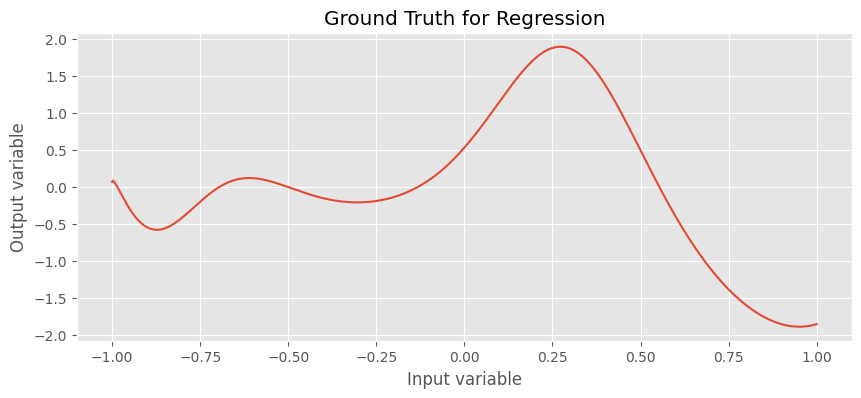

In [5]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
plt.title("Ground Truth for Regression")
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.show()

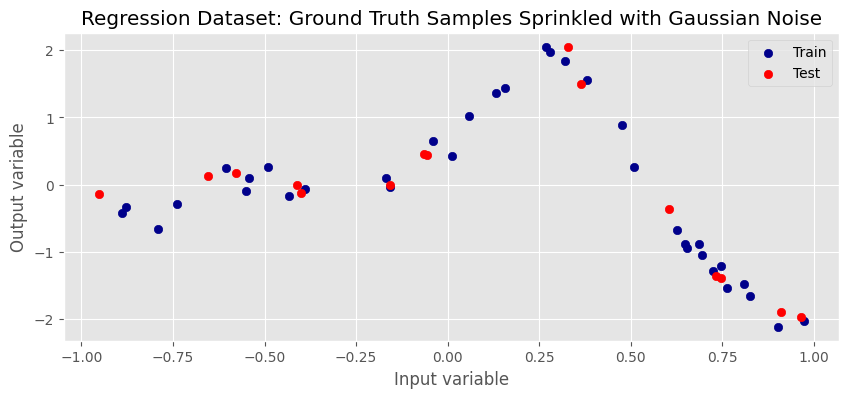

In [6]:
def generate_dataset(size=50, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)

x_tr, x_te, y_tr, y_te = generate_dataset()
plt.title("Regression Dataset: Ground Truth Samples Sprinkled with Gaussian Noise")
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

In [7]:
class FullCovGaussianLayer(nn.Module):
    def __init__(
        self, 
        input_dim, 
        output_dim, 
        prior_var = 0.8, 
        pre_trained_values = None   
        ):
        super(FullCovGaussianLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        # Prior parameters p(theta)

        # If no prior parameters are given, set them to zero mean and given variance
        if pre_trained_values is None:
            self.mu_p = torch.zeros(input_dim * output_dim + output_dim)
            self.chol_p = torch.eye(input_dim * output_dim + output_dim) * torch.sqrt(torch.tensor(prior_var))
            
        else:
            # Extract pre-trained values
            w_pre_mean = pre_trained_values[0]
            w_pre_log_var = pre_trained_values[1]
            b_pre_mean = pre_trained_values[2]
            b_pre_log_var = pre_trained_values[3]

            # Set priors to pre-trained values
            self.mu_p = torch.cat([w_pre_mean, b_pre_mean], dim=0)
            combined_log_vars = torch.cat([w_pre_log_var, b_pre_log_var], dim=0)
            self.chol_p = torch.diag(torch.exp(combined_log_vars / 2))
           

         # Variational parameters q(theta)
        self.mu_q = nn.Parameter(self.mu_p.clone(),requires_grad=True)
        self.chol_q = nn.Parameter(self.chol_p.clone(),requires_grad=True)


    def get_chol_q(self):
        # Extract the lower triangular part of the parameter
        L = torch.tril(self.chol_q, -1)        # Replace the diagonal with its softplus to ensure positivity
        # L = torch.tanh(L_raw)  # Keeps values small, allows both signs

        diag = torch.log1p(torch.exp(torch.diag(self.chol_q)))  # Softplus on original diagonal
        return L + torch.diag(diag)

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p(self):
        """Weight prior distribution"""
        return torch.distributions.MultivariateNormal(self.mu_p, scale_tril=self.chol_p)

    def q(self):
        """Variational weight posterior"""
        valid_chol = self.get_chol_q()

        return torch.distributions.MultivariateNormal(self.mu_q, scale_tril=valid_chol)

    
    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        return torch.distributions.kl_divergence(self.q(), self.p()).sum()
    
    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim
        num_samples = x.shape[0]

        # Sample the parameters and detach them from the hyperparameters graph
        param_sample = self.q().rsample((num_samples,))
        weights = param_sample[:,:self.input_dim * self.output_dim]  # Shape: (num_samples, input_dim * output_dim)
        weights = weights.view(num_samples, self.input_dim, self.output_dim)  # Reshape to (num_samples, input_dim, output_dim)

        biases = param_sample[:,self.input_dim * self.output_dim:].unsqueeze(1)  # Shape: (output_dim, num_samples)

        return x @ weights + biases




In [8]:
class LayerCovBNN(nn.Module):
    """BNN with layer-wise block diagonal covariance Gaussian distributions."""
    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.ELU(),
        noise_std=1.0,
        prior_var = 0.8,
        pre_trained_values = None
    ):
        super(LayerCovBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.noise_std = noise_std

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            # If no pre trained parameters are given, set them to zero mean and given variance
            if pre_trained_values is None:
                if i == 0:
                    self.network.append(FullCovGaussianLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                    self.network.append(self.activation)
                elif i == len(hidden_dims):
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                    )
                else:
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                    )
                    self.network.append(self.activation) 

            # Set to pre trained values
            else:
                if i == 0:
                    self.network.append(FullCovGaussianLayer(self.input_dim, self.hidden_dims[i], pre_trained_values = pre_trained_values[i]))
                    self.network.append(self.activation)
                elif i == len(hidden_dims):
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.output_dim, pre_trained_values = pre_trained_values[i])
                    )
                else:
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.hidden_dims[i], pre_trained_values = pre_trained_values[i])
                    )
                    self.network.append(self.activation)

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."
        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)

        # Propagate x through network
        for layer in self.network:
            if isinstance(layer, FullCovGaussianLayer):
                x = layer(x)
            else:
                x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x
    
    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, self.noise_std)
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl_divergence() for layer in self.network if isinstance(layer, FullCovGaussianLayer)])
    
    
    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl
   

In [12]:
bnn_model = LayerCovBNN(1, [4, 4], 1, noise_std=0.15, prior_var = 0.3)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-2
)

LayerCovBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): FullCovGaussianLayer()
    (1): ELU(alpha=1.0)
    (2): FullCovGaussianLayer()
    (3): ELU(alpha=1.0)
    (4): FullCovGaussianLayer()
  )
)


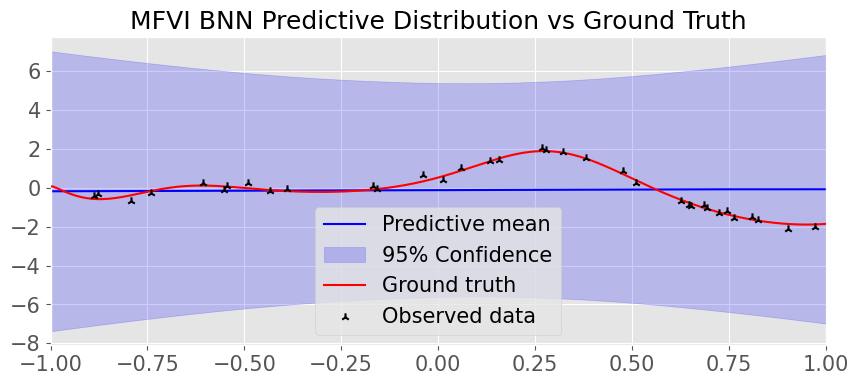

In [13]:
xs = np.linspace(-1, 1, 500)
num_samps = 1000

preds = bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps).squeeze(-1).detach().numpy()
pred_mean = preds.mean(0)
pred_std = preds.std(0)
plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

ys = normalised_ground_truth(xs)
plt.title("MFVI BNN Predictive Distribution vs Ground Truth", fontsize=18)
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.legend(fontsize=15, loc='lower center')
plt.xlim([-1, 1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

100%|██████████| 1000/1000 [00:25<00:00, 38.79it/s]


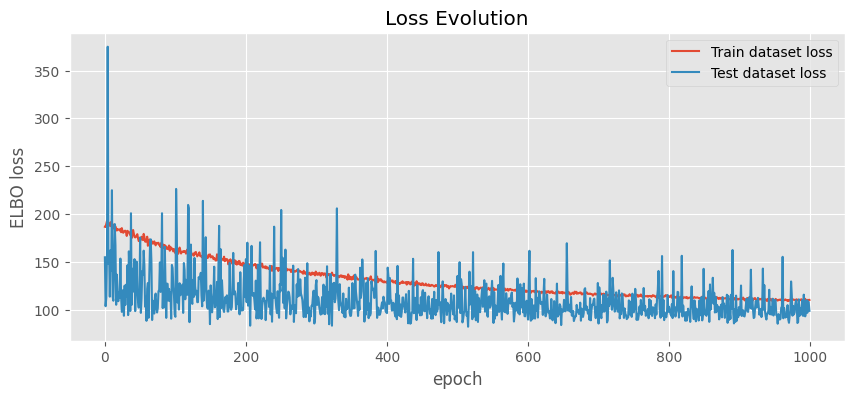

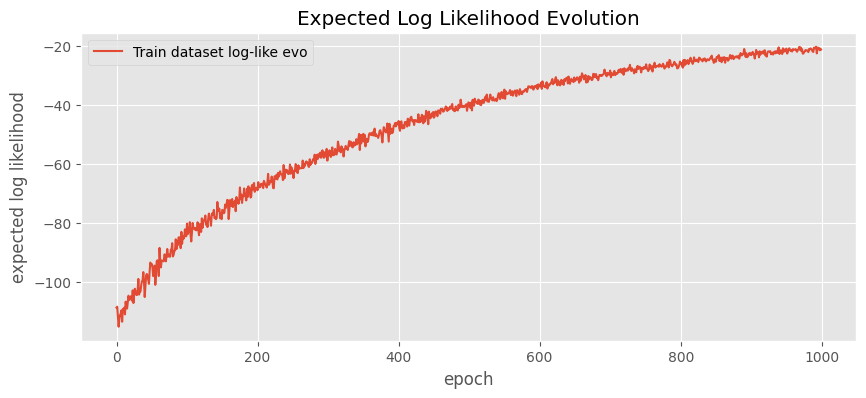

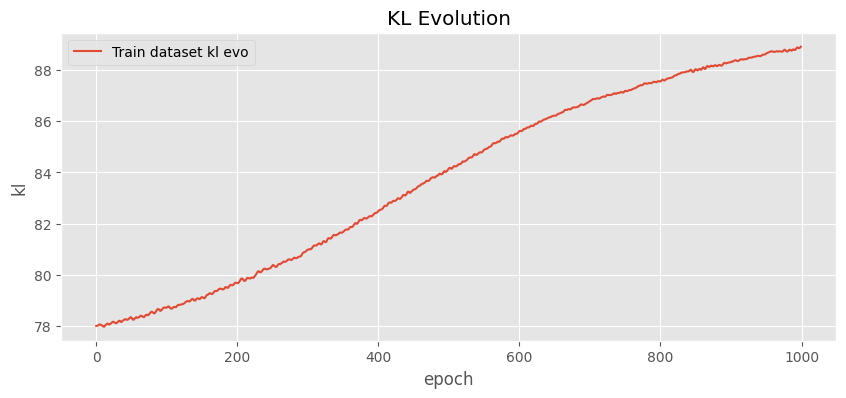

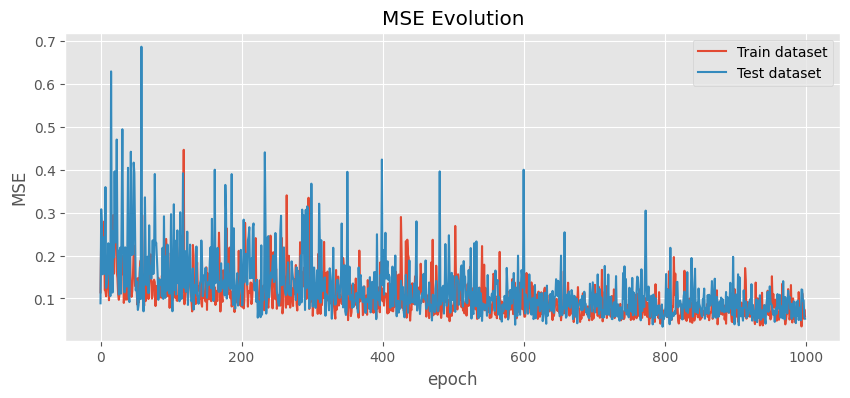

In [25]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

for epoch in tqdm(range(1000)):  # epochs
    opt.zero_grad()

    l, ll, kl = bnn_model.loss(x_tr, y_tr,num_samples = 1000)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(bnn_model(x_tr), y_tr.unsqueeze(0)).item())

    te_loss_evo.append(bnn_model.loss(x_te, y_te)[0].item())
    te_mse_loss_evo.append(aux_loss(bnn_model(x_te), y_te.unsqueeze(0)).item())

    l.backward()
    opt.step()
    # for layer in bnn_model.network:
    #     if isinstance(layer, FullCovGaussianLayer):
    #         layer.chol_q.data = torch.tril(layer.chol_q.data)

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

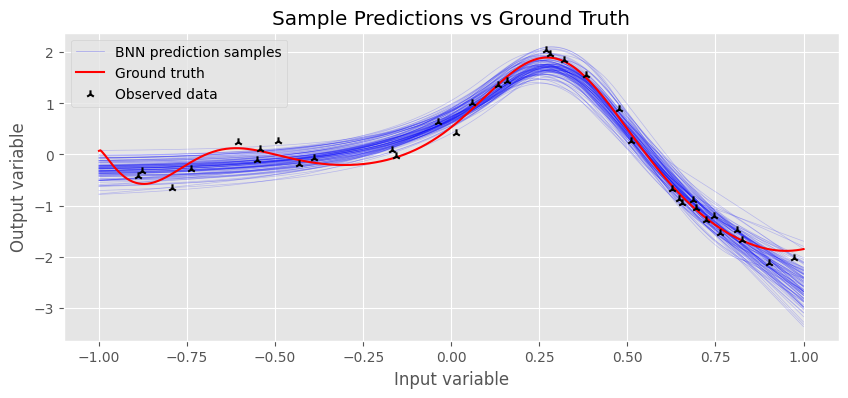

In [26]:
xs = np.linspace(-1, 1, 500)
num_samps = 100

preds = bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps).squeeze(-1).detach().numpy()
plt.plot(xs, preds[0,...], color='blue', linewidth=0.5, alpha=0.3, label='BNN prediction samples')
plt.plot(xs, preds[1:,...].T, color='blue', linewidth=0.5, alpha=0.2)

ys = normalised_ground_truth(xs)
plt.title("Sample Predictions vs Ground Truth")
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

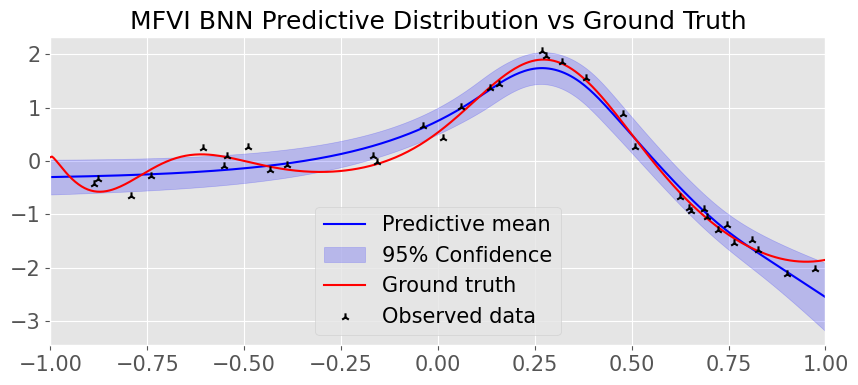

In [27]:
xs = np.linspace(-1, 1, 500)
num_samps = 1000

preds = bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps).squeeze(-1).detach().numpy()
pred_mean = preds.mean(0)
pred_std = preds.std(0)
plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

ys = normalised_ground_truth(xs)
plt.title("MFVI BNN Predictive Distribution vs Ground Truth", fontsize=18)
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.legend(fontsize=15, loc='lower center')
plt.xlim([-1, 1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

In [30]:
bnn_model.network[0].mu_q

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [31]:
l, ll, kl = bnn_model.loss(x_tr, y_tr,num_samples = 1000)


l.backward()

In [28]:
bnn_model.network[0].chol_q

Parameter containing:
tensor([[-2.3673e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.3199e-02, -1.1747e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 5.7560e-02, -2.7571e-02, -1.2474e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.2880e-03, -5.4746e-03, -1.3486e-02, -1.1623e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.8888e-02, -8.6310e-04,  7.1176e-04, -1.9250e-03, -3.3932e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.6319e-03, -7.9958e-02, -1.6647e-02, -6.5035e-03,  4.3401e-03,
         -1.4675e+00,  0.0000e+00,  0.0000e+00],
        [ 5.0960e-03, -6.2376e-03, -9.2037e-02, -1.0881e-02,  4.7691e-02,
         -3.7270e-02, -1.5813e+00,  0.0000e+00],
        [-8.6361e-03, -1.1078e-02, -5.9489e-03, -7.5874e-02, -5.1945e-02,
         -2.0145e-02, -1.9898e-02, -1.5621e

In [30]:
y_te.unsqueeze(0).repeat(10, 1, 1).shape

torch.Size([10, 15, 1])